# Simple moutain formation example

This notebook reproduces the [mountain example](https://fastscape-lem.github.io/fastscapelib-fortran/#_mountain_f90) provided in the fastscapelib-fortran library. This is the most common example of a landscape evolution model in action.

In [1]:
import numpy as np
import xsimlab as xs
import matplotlib.pyplot as plt
import fastscape

%matplotlib inline

In [2]:
print('xarray-simlab version: ', xs.__version__)
print('fastscape version: ', fastscape.__version__)

xarray-simlab version:  0.4.1
fastscape version:  0.1.0beta


## Import and inspect the model

We use the basic model available in [fastscape](https://fastscape.readthedocs.io/en/latest/).

In [3]:
from fastscape.models import basic_model

In [4]:
basic_model

<xsimlab.Model (16 processes, 8 inputs)>
grid
    shape           [in] ('shape_yx',) nb. of grid nodes in (y, x)
    length          [in] ('shape_yx',) total grid length in (y, x)
fs_context
boundary
    status          [in] () or ('border',) node status at borders
uplift
    rate            [in] () or ('y', 'x') uplift rate
tectonics
init_topography
surf2erode
flow
drainage
spl
    area_exp        [in] drainage area exponent
    slope_exp       [in] slope exponent
    k_coef          [in] () or ('y', 'x') bedrock channel incision ...
diffusion
    diffusivity     [in] () or ('y', 'x') diffusivity (transport co...
init_erosion
erosion
vmotion
topography
terrain

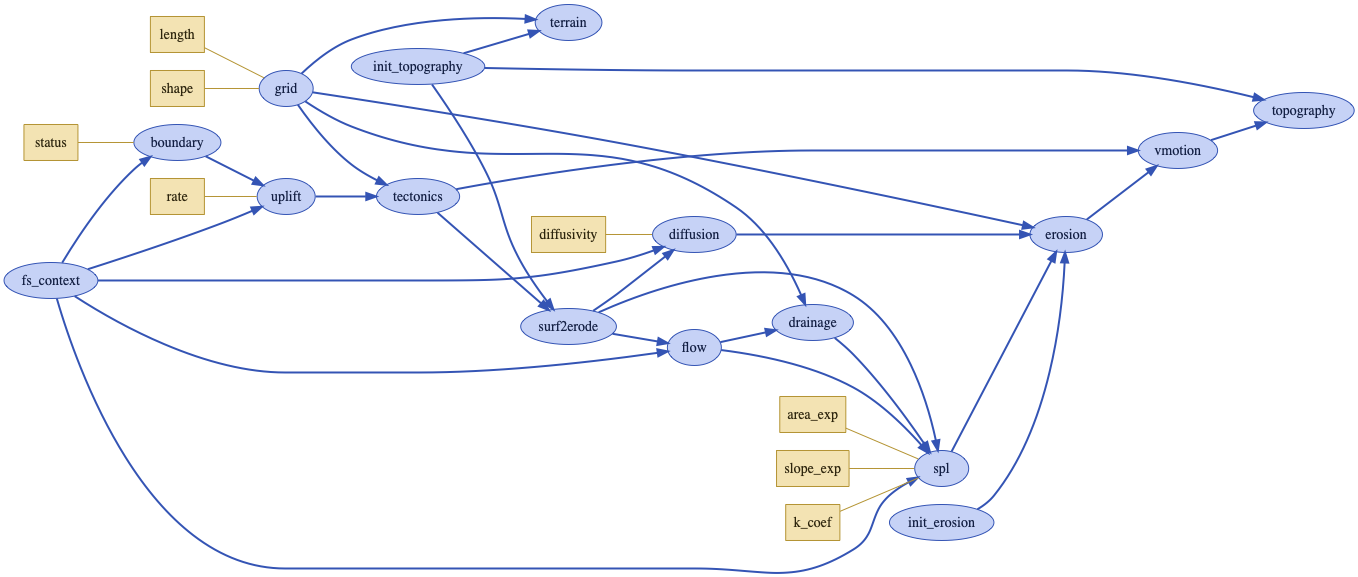

In [5]:
basic_model.visualize(show_inputs=True)

## Model setup

**Note**: One important difference between this model and the example shown in the fastscapelib-fortran library is that linear diffusion is here computed using the same topographic surface than the one used for computing stream power channel erosion. In fastscapelib-fortran, diffusion is always computed after applying channel erosion on the topographic surface, which makes it more "tolerant" to large time steps.

While it is possible to customize `basic_model` to mimic the behavior of fastscapelib-fortran (e.g., by replacing the diffusion process by another (sub)class), we keep the "apply-combine" approach here for erosion processes for more flexibility. Even if those processes are applied sequentially, setting large time steps has a significant impact on the solution as the latter is is only partially implicit (when considering the processes all together).

Here below we set time steps of 20000 years (5 times shorter than the same example in fastscapelib-fortran), for an overall simulation time of 4 million years.

In [6]:
in_ds = xs.create_setup(
    model=basic_model,
    clocks={
        'time': np.arange(0, 4e6 + 2e4, 2e4),
        'out': np.arange(0, 4e6 + 1e5, 1e5),
    },
    master_clock='time',
    input_vars={
        'grid__shape': [401, 401],
        'grid__length': [1e5, 1e5],
        'boundary__status': 'fixed_value',
        'uplift__rate': 1e-3,
        'spl': {
            'k_coef': 2e-6,
            'area_exp': 0.6,
            'slope_exp': 1.5
        },
        'diffusion__diffusivity': 1e-1
    },
    output_vars={
        'topography__elevation': 'out',
        'spl__chi': 'out',
    }
)

in_ds

<xarray.Dataset>
Dimensions:                 (out: 41, shape_yx: 2, time: 201)
Coordinates:
  * time                    (time) float64 0.0 2e+04 4e+04 ... 3.98e+06 4e+06
  * out                     (out) float64 0.0 1e+05 2e+05 ... 3.9e+06 4e+06
Dimensions without coordinates: shape_yx
Data variables:
    grid__shape             (shape_yx) int64 401 401
    grid__length            (shape_yx) float64 1e+05 1e+05
    boundary__status        <U11 'fixed_value'
    uplift__rate            float64 0.001
    spl__k_coef             float64 2e-06
    spl__area_exp           float64 0.6
    spl__slope_exp          float64 1.5
    diffusion__diffusivity  float64 0.1

## Run the model


In [7]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=basic_model)

In [8]:
out_ds

<xarray.Dataset>
Dimensions:                 (border: 4, out: 41, shape_yx: 2, time: 201, x: 401, y: 401)
Coordinates:
  * border                  (border) <U6 'left' 'right' 'top' 'bottom'
  * out                     (out) float64 0.0 1e+05 2e+05 ... 3.9e+06 4e+06
  * time                    (time) float64 0.0 2e+04 4e+04 ... 3.98e+06 4e+06
  * x                       (x) float64 0.0 250.0 500.0 ... 9.975e+04 1e+05
  * y                       (y) float64 0.0 250.0 500.0 ... 9.975e+04 1e+05
Dimensions without coordinates: shape_yx
Data variables:
    boundary__status        <U11 'fixed_value'
    diffusion__diffusivity  float64 0.1
    grid__length            (shape_yx) float64 1e+05 1e+05
    grid__shape             (shape_yx) int64 401 401
    spl__area_exp           float64 0.6
    spl__chi                (out, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    spl__k_coef             float64 2e-06
    spl__slope_exp          float64 1.5
    topography__elevation   (out, y, x) float6

## Plot the outputs

Plot the $\chi$ integrated drainage area.

In [9]:
import hvplot.xarray
from xshade import hillshade


chi_plot = out_ds.spl__chi.hvplot.image(
    x='x', y='y', clim=(0, 1e4),
    width=550, height=450,
    cmap=plt.cm.magma, groupby='out'
)

hillshade_plot = hillshade(out_ds, 'out').hvplot.image(
    x='x', y='y', cmap=plt.cm.gray, alpha=0.4,
    colorbar=False, hover=False, groupby='out'
)

chi_plot * hillshade_plot

:DynamicMap   [out]
   :Overlay
      .Image.I  :Image   [x,y]   (spl__chi)
      .Image.II :Image   [x,y]   (hillshade)